In [31]:
import numpy as np
import pandas as pd
from collections import defaultdict
from kmodes.kmodes import KModes
from matplotlib import pyplot as plt
from prince import FAMD, MCA
from sklearn import datasets, decomposition
from sklearn import cluster as cl
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

# Business context: 
A bank wants to sell products to its customers, and it seeks to understand its customers better in order to create targeted products for them.
# Business question: 
Cluster customers of the bank by their banking behaviours, to create personas with shared behavioural trends that the bank and create targeted products to.

# Prepare dataset

## Create dataframe banking_behaviour, from which clustering will be done

In [7]:
twm_customer = pd.read_csv("Data/twm_customer.csv", sep = ';')
print(twm_customer.head())

   cust_id  income  age  years_with_bank  nbr_children gender  marital_status  \
0  1362691   26150   46                5             1     M                2   
1  1362487    6605   71                1             0     M                2   
2  1363160   18548   38                8             0     F                1   
3  1362752   47668   54                3             0     F                1   
4  1362548   44554   59                9             2     F                4   

  name_prefix                                         first_name  \
0              Donald                                        ...   
1              ChingDyi                                      ...   
2              Rosa                                          ...   
3              Lisa                                          ...   
4              Barbara                                       ...   

                                           last_name  street_nbr  \
0  Marek                            

In [8]:
twm_accounts = pd.read_csv("Data/twm_accounts.csv", sep = ';')
print(twm_accounts.head())

           acct_nbr  cust_id acct_type account_active acct_start_date  \
0          13628063  1362806      SV               Y       10.12.1995   
1  4561143213627090  1362709      CC               Y        15.3.1993   
2  4561143213628360  1362836      CC               Y        18.3.1992   
3          13633112  1363311      CK               Y         6.7.1995   
4  4561143213633610  1363361      CC               Y        17.6.1994   

  acct_end_date  starting_balance  ending_balance  
0           NaN           1430.22          284.58  
1           NaN            266.34          496.15  
2           NaN             55.90         1000.00  
3           NaN          11017.13          968.46  
4           NaN            849.37          462.28  


In [9]:
twm_transactions = pd.read_csv("Data/twm_transactions.csv", sep = ';')
print(twm_transactions.head())

   tran_id  acct_nbr  tran_amt  principal_amt  interest_amt  new_balance  \
0       27  13625623      0.00           0.00           0.0      3753.34   
1       97  13628392      0.00           0.00           0.0       254.49   
2       21  13630842    -97.57         -97.57           0.0      3819.56   
3       44  13631412     -0.15          -0.15           0.0       224.05   
4       31  13625722      0.00           0.00           0.0       240.55   

    tran_date  tran_time channel tran_code  
0  21.10.1995     121656      A       IQ    
1    5.2.1995     153053      V       IQ    
2   23.7.1995          0      P       WD    
3   30.1.1995          0              FK    
4   25.1.1995     204521      B       IQ    


In [10]:
# Function to strip whitepsace from ends of string, but will take any input and return it if it's not a string
def fix(input):
    try:
        input = input.strip()
    except:
        pass
    return input

In [11]:
# Fix all the dataframes, removing whitespace from start and end of strings

for colname in twm_customer.columns:
    twm_customer[colname] = twm_customer[colname].apply(fix)

for colname in twm_accounts.columns:
    twm_accounts[colname] = twm_accounts[colname].apply(fix)

for colname in twm_transactions.columns:
    twm_transactions[colname] = twm_transactions[colname].apply(fix)

In [13]:
banking_behaviour = pd.DataFrame()
banking_behaviour["cust_id"] = twm_customer['cust_id']
print(banking_behaviour)

     cust_id
0    1362691
1    1362487
2    1363160
3    1362752
4    1362548
..       ...
742  1363324
743  1362895
744  1362569
745  1363364
746  1363303

[747 rows x 1 columns]


In [14]:
banking_behaviour = pd.merge(banking_behaviour, twm_accounts, on='cust_id', how='right')
print(banking_behaviour)

      cust_id          acct_nbr acct_type account_active acct_start_date  \
0     1362806          13628063        SV              Y      10.12.1995   
1     1362709  4561143213627090        CC              Y       15.3.1993   
2     1362836  4561143213628360        CC              Y       18.3.1992   
3     1363311          13633112        CK              Y        6.7.1995   
4     1363361  4561143213633610        CC              Y       17.6.1994   
...       ...               ...       ...            ...             ...   
1404  1362556  4561143213625560        CC              N       20.1.1992   
1405  1362624  4561143213626240        CC              Y      29.11.1990   
1406  1362875  4561143213628750        CC              Y       24.2.1989   
1407  1362654          13626543        SV              Y      17.10.1992   
1408  1362703          13627032        CK              Y       18.9.1994   

     acct_end_date  starting_balance  ending_balance  
0              NaN           143

In [15]:
banking_behaviour = banking_behaviour.drop(['acct_start_date', 'acct_end_date'], axis=1)

In [16]:
banking_behaviour["account_active"] = banking_behaviour["account_active"].map({"N": 0, "Y": 1})

In [17]:
print(banking_behaviour)

      cust_id          acct_nbr acct_type  account_active  starting_balance  \
0     1362806          13628063        SV               1           1430.22   
1     1362709  4561143213627090        CC               1            266.34   
2     1362836  4561143213628360        CC               1             55.90   
3     1363311          13633112        CK               1          11017.13   
4     1363361  4561143213633610        CC               1            849.37   
...       ...               ...       ...             ...               ...   
1404  1362556  4561143213625560        CC               0           1433.94   
1405  1362624  4561143213626240        CC               1            632.75   
1406  1362875  4561143213628750        CC               1           2810.91   
1407  1362654          13626543        SV               1            784.53   
1408  1362703          13627032        CK               1           3649.18   

      ending_balance  
0             284.58  
1    

## Populate banking_behaviour with account transaction averages and number of transactions.

In [18]:
# Show account type in twm_transactions by pulling info from twm_accounts
twm_accounts['acct_nbr'] = twm_accounts['acct_nbr'].astype(int)
twm_transactions = pd.merge(twm_transactions, twm_accounts[['acct_nbr', 'acct_type']], on='acct_nbr', how='left')
print(twm_transactions)

       tran_id          acct_nbr  tran_amt  principal_amt  interest_amt  \
0           27          13625623      0.00           0.00           0.0   
1           97          13628392      0.00           0.00           0.0   
2           21          13630842    -97.57         -97.57           0.0   
3           44          13631412     -0.15          -0.15           0.0   
4           31          13625722      0.00           0.00           0.0   
...        ...               ...       ...            ...           ...   
77575       77          13631752    -95.71         -95.71           0.0   
77576       94          13626772    -93.90         -93.90           0.0   
77577       42          13625262    -10.35         -10.35           0.0   
77578       98          13627052   -423.80        -423.80           0.0   
77579       57  4561143213632570      0.00           0.00           0.0   

       new_balance   tran_date  tran_time channel tran_code acct_type  
0          3753.34  21.10.1

In [2]:
# get average cc withdraw amount for each cc account
twm_transactions_filtered = twm_transactions[(twm_transactions["acct_type"] == "CC") & (twm_transactions["tran_amt"] < 0)]
grouped = twm_transactions_filtered.groupby("acct_nbr")
twm_transactions_grouped = grouped['tran_amt'].mean().reset_index()
twm_transactions_grouped.rename(columns={'tran_amt': 'cc_av_wd'}, inplace=True)
twm_transactions_grouped["acct_nbr"] = twm_transactions_grouped["acct_nbr"].astype(str)
print(twm_transactions_grouped)

NameError: name 'twm_transactions' is not defined

In [1]:
# get average cc payment amount for each cc account
twm_transactions_filtered = twm_transactions[(twm_transactions["acct_type"] == "CC") & (twm_transactions["tran_amt"] > 0)]
grouped2 = twm_transactions_filtered.groupby("acct_nbr")
twm_transactions_grouped2 = grouped['tran_amt'].mean().reset_index()
twm_transactions_grouped2.rename(columns={'tran_amt': 'cc_av_pm'}, inplace=True)
twm_transactions_grouped2["acct_nbr"] = twm_transactions_grouped2["acct_nbr"].astype(str)
print(twm_transactions_grouped2)

NameError: name 'twm_transactions' is not defined

In [21]:
# Number of withdraws from cc
twm_transactions_filtered = twm_transactions[(twm_transactions["acct_type"] == "CC") & (twm_transactions["tran_amt"] < 0)]
grouped = twm_transactions_filtered.groupby("acct_nbr")
twm_transactions_grouped3 = grouped['tran_amt'].agg(lambda x: len(x)).reset_index()
twm_transactions_grouped3.rename(columns={'tran_amt': 'cc_n_wd'}, inplace=True)
twm_transactions_grouped3["acct_nbr"] = twm_transactions_grouped3["acct_nbr"].astype(str)
print(twm_transactions_grouped3)

             acct_nbr  cc_n_wd
0    4561143213624800       17
1    4561143213624840       39
2    4561143213624850       57
3    4561143213624870       26
4    4561143213624890       25
..                ...      ...
430  4561143213634820       41
431  4561143213634830       55
432  4561143213634840       26
433  4561143213634850       13
434  4561143213634920       15

[435 rows x 2 columns]


In [22]:
# Number of payments to cc
twm_transactions_filtered = twm_transactions[(twm_transactions["acct_type"] == "CC") & (twm_transactions["tran_amt"] > 0)]
grouped = twm_transactions_filtered.groupby("acct_nbr")
twm_transactions_grouped4 = grouped['tran_amt'].agg(lambda x: len(x)).reset_index()
twm_transactions_grouped4.rename(columns={'tran_amt': 'cc_n_pm'}, inplace=True)
twm_transactions_grouped4["acct_nbr"] = twm_transactions_grouped4["acct_nbr"].astype(str)
print(twm_transactions_grouped4)

             acct_nbr  cc_n_pm
0    4561143213624800       12
1    4561143213624840       12
2    4561143213624850       12
3    4561143213624870        4
4    4561143213624890        9
..                ...      ...
445  4561143213634820        8
446  4561143213634830       12
447  4561143213634840       11
448  4561143213634850        2
449  4561143213634920       12

[450 rows x 2 columns]


In [23]:
# Average chequing account withdraws 
twm_transactions_filtered = twm_transactions[(twm_transactions["acct_type"] == "CK") & (twm_transactions["tran_amt"] < 0)]
grouped = twm_transactions_filtered.groupby("acct_nbr")
twm_transactions_grouped5 = grouped['tran_amt'].mean().reset_index()
twm_transactions_grouped5.rename(columns={'tran_amt': 'ck_av_wd'}, inplace=True)
twm_transactions_grouped5["acct_nbr"] = twm_transactions_grouped5["acct_nbr"].astype(str)
print(twm_transactions_grouped5)

     acct_nbr    ck_av_wd
0    13624802 -102.566957
1    13624842  -71.081667
2    13624852  -77.378060
3    13624862 -112.306667
4    13624872  -72.242500
..        ...         ...
512  13634832  -31.745556
513  13634842  -93.338333
514  13634922 -184.426528
515  13634932 -143.906615
516  13634952  -96.404912

[517 rows x 2 columns]


In [24]:
# Average chequing account deposits 
twm_transactions_filtered = twm_transactions[(twm_transactions["acct_type"] == "CK") & (twm_transactions["tran_amt"] > 0)]
grouped = twm_transactions_filtered.groupby("acct_nbr")
twm_transactions_grouped6 = grouped['tran_amt'].mean().reset_index()
twm_transactions_grouped6.rename(columns={'tran_amt': 'ck_av_dp'}, inplace=True)
twm_transactions_grouped6["acct_nbr"] = twm_transactions_grouped6["acct_nbr"].astype(str)
print(twm_transactions_grouped6)

     acct_nbr     ck_av_dp
0    13624802   488.009286
1    13624842   162.483750
2    13624852   313.752500
3    13624862     5.433846
4    13624872    66.647857
..        ...          ...
512  13634832   195.753077
513  13634842   167.022500
514  13634922  2005.706667
515  13634932   278.104737
516  13634952   122.730800

[517 rows x 2 columns]


In [25]:
# Number of withdraws from chequing 
twm_transactions_filtered = twm_transactions[(twm_transactions["acct_type"] == "CK") & (twm_transactions["tran_amt"] < 0)]
grouped = twm_transactions_filtered.groupby("acct_nbr")
twm_transactions_grouped7 = grouped['tran_amt'].agg(lambda x: len(x)).reset_index()
twm_transactions_grouped7.rename(columns={'tran_amt': 'ck_n_wd'}, inplace=True)
twm_transactions_grouped7["acct_nbr"] = twm_transactions_grouped7["acct_nbr"].astype(str)
print(twm_transactions_grouped7)

     acct_nbr  ck_n_wd
0    13624802       69
1    13624842       72
2    13624852       67
3    13624862        9
4    13624872       32
..        ...      ...
512  13634832       72
513  13634842       54
514  13634922       72
515  13634932       65
516  13634952       57

[517 rows x 2 columns]


In [26]:
# Number of deposits from chequing 
twm_transactions_filtered = twm_transactions[(twm_transactions["acct_type"] == "CK") & (twm_transactions["tran_amt"] > 0)]
grouped = twm_transactions_filtered.groupby("acct_nbr")
twm_transactions_grouped8 = grouped['tran_amt'].agg(lambda x: len(x)).reset_index()
twm_transactions_grouped8.rename(columns={'tran_amt': 'ck_n_dp'}, inplace=True)
twm_transactions_grouped8["acct_nbr"] = twm_transactions_grouped8["acct_nbr"].astype(str)
print(twm_transactions_grouped8)

     acct_nbr  ck_n_dp
0    13624802       14
1    13624842       16
2    13624852       16
3    13624862       13
4    13624872       14
..        ...      ...
512  13634832       13
513  13634842       16
514  13634922        6
515  13634932       19
516  13634952       25

[517 rows x 2 columns]


In [27]:
# Average amount of withdraw from savings acct
twm_transactions_filtered = twm_transactions[(twm_transactions["acct_type"] == "SV") & (twm_transactions["tran_amt"] < 0)]
grouped = twm_transactions_filtered.groupby("acct_nbr")
twm_transactions_grouped9 = grouped['tran_amt'].mean().reset_index()
twm_transactions_grouped9.rename(columns={'tran_amt': 'sv_av_wd'}, inplace=True)
twm_transactions_grouped9["acct_nbr"] = twm_transactions_grouped9["acct_nbr"].astype(str)
print(twm_transactions_grouped9)

     acct_nbr    sv_av_wd
0    13624803 -358.210000
1    13624843 -257.342500
2    13624863  -85.782222
3    13624873 -109.025714
4    13624893 -315.612500
..        ...         ...
338  13634823  -96.991000
339  13634913 -156.345556
340  13634923 -596.042000
341  13634933 -129.936667
342  13634953  -93.240000

[343 rows x 2 columns]


In [28]:
# Average amount of deposit to savings acct
twm_transactions_filtered = twm_transactions[(twm_transactions["acct_type"] == "SV") & (twm_transactions["tran_amt"] > 0)]
grouped = twm_transactions_filtered.groupby("acct_nbr")
twm_transactions_grouped10 = grouped['tran_amt'].mean().reset_index()
twm_transactions_grouped10.rename(columns={'tran_amt': 'sv_av_dp'}, inplace=True)
twm_transactions_grouped10["acct_nbr"] = twm_transactions_grouped10["acct_nbr"].astype(str)
print(twm_transactions_grouped10)

     acct_nbr    sv_av_dp
0    13624803  106.397778
1    13624843  102.035517
2    13624863   37.737500
3    13624873   15.542500
4    13624893   58.390667
..        ...         ...
415  13634903    2.853333
416  13634913  152.435000
417  13634923  184.958235
418  13634933   91.095455
419  13634953   60.617391

[420 rows x 2 columns]


In [29]:
# Number of withdraws from savings
twm_transactions_filtered = twm_transactions[(twm_transactions["acct_type"] == "SV") & (twm_transactions["tran_amt"] < 0)]
grouped = twm_transactions_filtered.groupby("acct_nbr")
twm_transactions_grouped11 = grouped['tran_amt'].agg(lambda x: len(x)).reset_index()
twm_transactions_grouped11.rename(columns={'tran_amt': 'sv_n_wd'}, inplace=True)
twm_transactions_grouped11["acct_nbr"] = twm_transactions_grouped11["acct_nbr"].astype(str)
print(twm_transactions_grouped11)

     acct_nbr  sv_n_wd
0    13624803        4
1    13624843        4
2    13624863        9
3    13624873        7
4    13624893        4
..        ...      ...
338  13634823       10
339  13634913        9
340  13634923        5
341  13634933        6
342  13634953       10

[343 rows x 2 columns]


In [30]:
# Number of deposits to savings
twm_transactions_filtered = twm_transactions[(twm_transactions["acct_type"] == "SV") & (twm_transactions["tran_amt"] > 0)]
grouped = twm_transactions_filtered.groupby("acct_nbr")
twm_transactions_grouped12 = grouped['tran_amt'].agg(lambda x: len(x)).reset_index()
twm_transactions_grouped12.rename(columns={'tran_amt': 'sv_n_dp'}, inplace=True)
twm_transactions_grouped12["acct_nbr"] = twm_transactions_grouped12["acct_nbr"].astype(str)
print(twm_transactions_grouped12)

     acct_nbr  sv_n_dp
0    13624803       18
1    13624843       29
2    13624863       16
3    13624873        8
4    13624893       15
..        ...      ...
415  13634903       12
416  13634913        8
417  13634923       17
418  13634933       11
419  13634953       23

[420 rows x 2 columns]


In [31]:
banking_behaviour["acct_nbr"] = banking_behaviour["acct_nbr"].astype(str)
twm_transactions_grouped["acct_nbr"] = twm_transactions_grouped["acct_nbr"].astype(str)

In [32]:
banking_behaviour_merged = banking_behaviour.merge(twm_transactions_grouped, on='acct_nbr', how='left')

banking_behaviour_merged = banking_behaviour_merged.merge(twm_transactions_grouped2, on='acct_nbr', how='left')

banking_behaviour_merged = banking_behaviour_merged.merge(twm_transactions_grouped3, on='acct_nbr', how='left')

banking_behaviour_merged = banking_behaviour_merged.merge(twm_transactions_grouped4, on='acct_nbr', how='left')

banking_behaviour_merged = banking_behaviour_merged.merge(twm_transactions_grouped5, on='acct_nbr', how='left')

banking_behaviour_merged = banking_behaviour_merged.merge(twm_transactions_grouped6, on='acct_nbr', how='left')

banking_behaviour_merged = banking_behaviour_merged.merge(twm_transactions_grouped7, on='acct_nbr', how='left')

banking_behaviour_merged = banking_behaviour_merged.merge(twm_transactions_grouped8, on='acct_nbr', how='left')

banking_behaviour_merged = banking_behaviour_merged.merge(twm_transactions_grouped9, on='acct_nbr', how='left')

banking_behaviour_merged = banking_behaviour_merged.merge(twm_transactions_grouped10, on='acct_nbr', how='left')

banking_behaviour_merged = banking_behaviour_merged.merge(twm_transactions_grouped11, on='acct_nbr', how='left')

banking_behaviour_merged = banking_behaviour_merged.merge(twm_transactions_grouped12, on='acct_nbr', how='left')

print(banking_behaviour_merged)

      cust_id          acct_nbr acct_type  account_active  starting_balance  \
0     1362806          13628063        SV               1           1430.22   
1     1362709  4561143213627090        CC               1            266.34   
2     1362836  4561143213628360        CC               1             55.90   
3     1363311          13633112        CK               1          11017.13   
4     1363361  4561143213633610        CC               1            849.37   
...       ...               ...       ...             ...               ...   
1404  1362556  4561143213625560        CC               0           1433.94   
1405  1362624  4561143213626240        CC               1            632.75   
1406  1362875  4561143213628750        CC               1           2810.91   
1407  1362654          13626543        SV               1            784.53   
1408  1362703          13627032        CK               1           3649.18   

      ending_balance    cc_av_wd    cc_av_pm  cc_n_

In [21]:
banking_behaviour_merged = pd.read_csv('Data/banking_behaviour_data/banking_behaviour_data.csv')

In [23]:
# Add new column for ratio of end to start balance 
banking_behaviour_merged['end_start_balance_ratio'] = np.where(banking_behaviour_merged['starting_balance'] == 0, np.nan, banking_behaviour_merged['ending_balance'] / banking_behaviour_merged['starting_balance'])

In [28]:
banking_behaviour_merged.to_csv('Data/banking_behaviour_data/banking_behaviour_data.csv', index = False)

# Explore data, remove outliers & scale data

In [92]:
bk_behaviour = pd.read_csv('Data/banking_behaviour_data/banking_behaviour_data.csv')

In [86]:
# Find outliers
column_names = bk_behaviour.columns[-13:]
for column_name in column_names:
    print(f"Processing column: {column_name}")
    z_score = stats.zscore(bk_behaviour[column_name])
    abs_z_score = np.abs(z_score)
    outliers = bk_behaviour[column_name][(abs_z_score > 3)].tolist()
    if len(outliers) > 0:
        print(f"Outliers found in column: {column_name}")
        print(f"Outlier values: {outliers}")
    else:
        print(f"No outliers found in column: {column_name}")


Processing column: cc_av_wd
No outliers found in column: cc_av_wd
Processing column: cc_av_pm
No outliers found in column: cc_av_pm
Processing column: cc_n_wd
No outliers found in column: cc_n_wd
Processing column: cc_n_pm
No outliers found in column: cc_n_pm
Processing column: ck_av_wd
No outliers found in column: ck_av_wd
Processing column: ck_av_dp
No outliers found in column: ck_av_dp
Processing column: ck_n_wd
No outliers found in column: ck_n_wd
Processing column: ck_n_dp
No outliers found in column: ck_n_dp
Processing column: sv_av_wd
No outliers found in column: sv_av_wd
Processing column: sv_av_dp
No outliers found in column: sv_av_dp
Processing column: sv_n_wd
No outliers found in column: sv_n_wd
Processing column: sv_n_dp
No outliers found in column: sv_n_dp
Processing column: end_start_balance_ratio
No outliers found in column: end_start_balance_ratio


/Users/brigitte/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


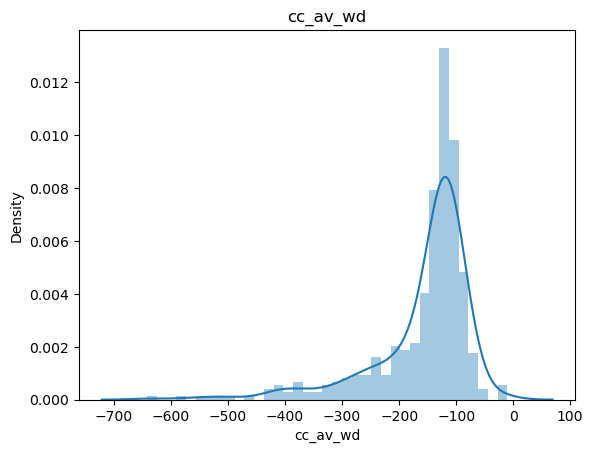

/Users/brigitte/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


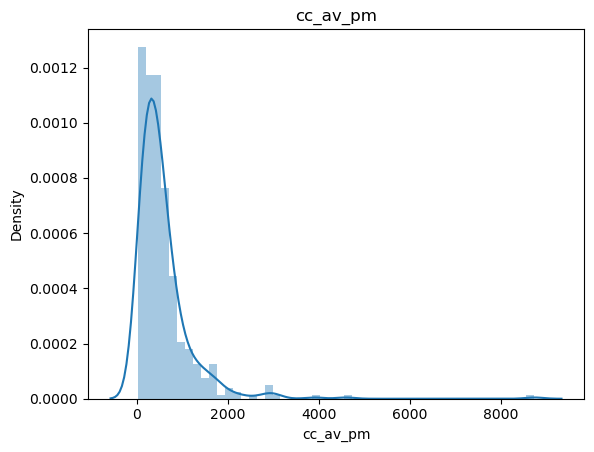

/Users/brigitte/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


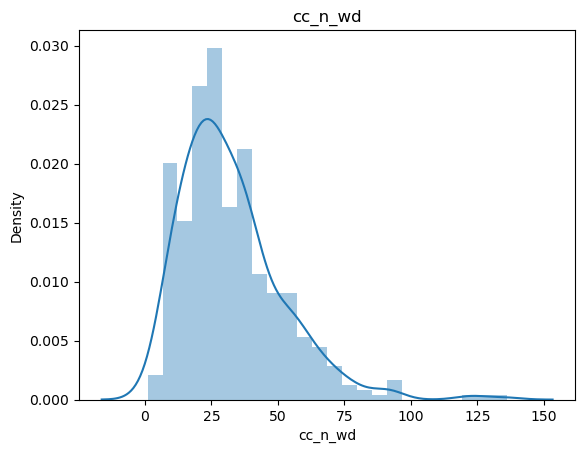

/Users/brigitte/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


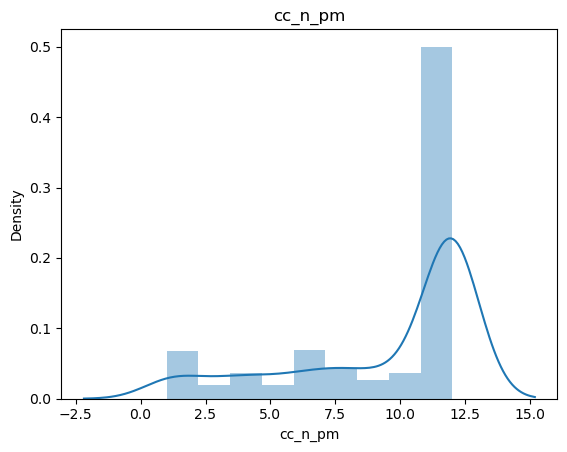

/Users/brigitte/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


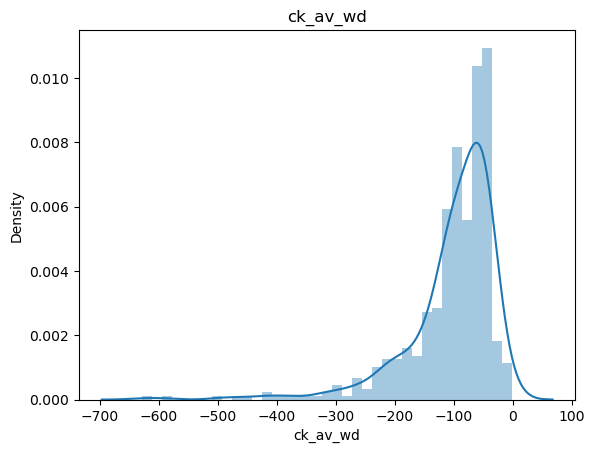

/Users/brigitte/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


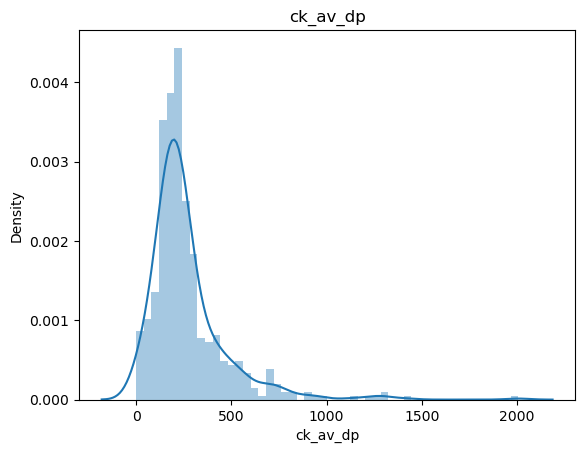

/Users/brigitte/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


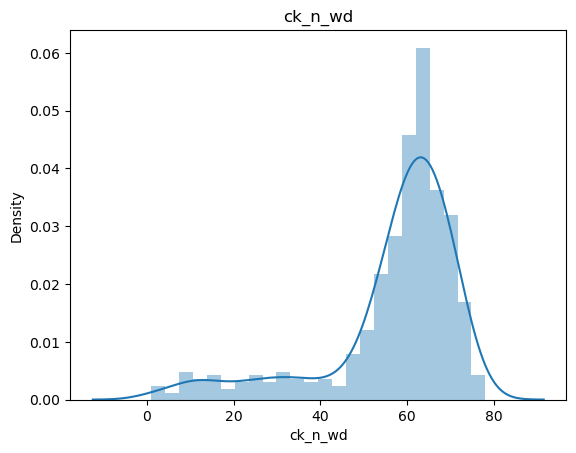

/Users/brigitte/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


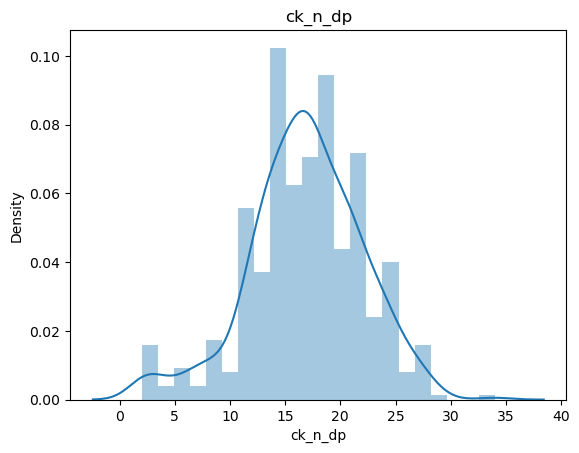

/Users/brigitte/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


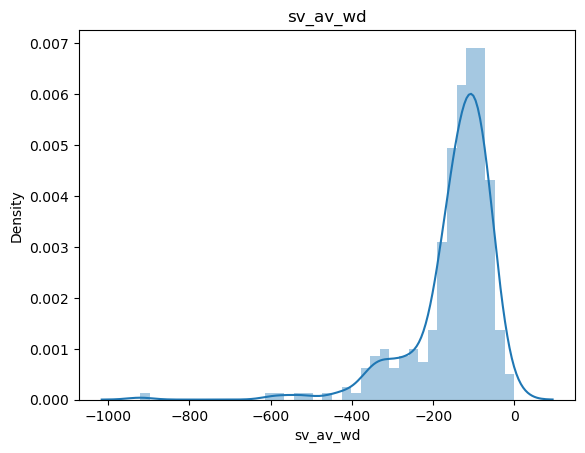

/Users/brigitte/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


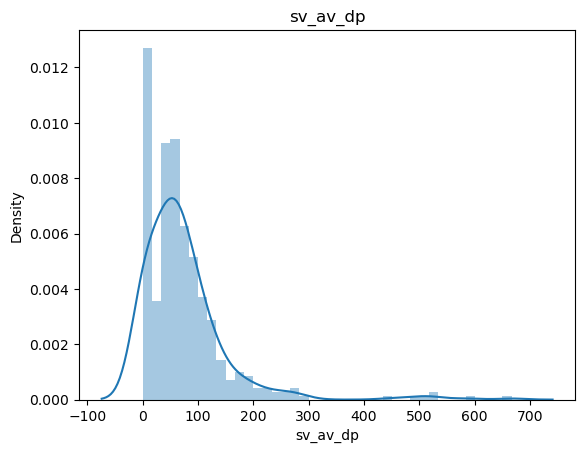

/Users/brigitte/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


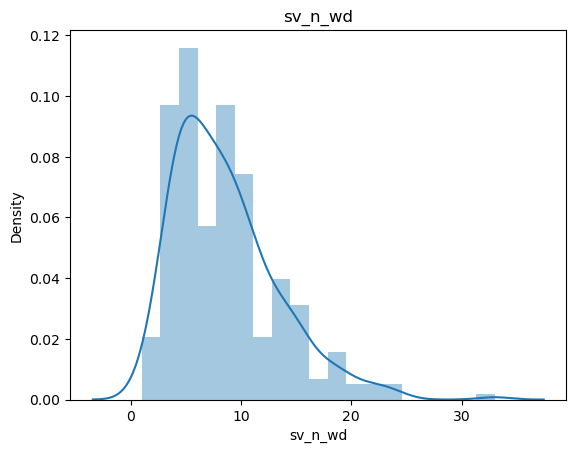

/Users/brigitte/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


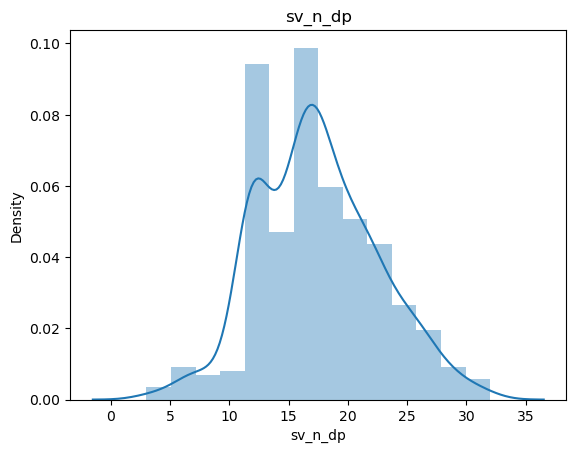

/Users/brigitte/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


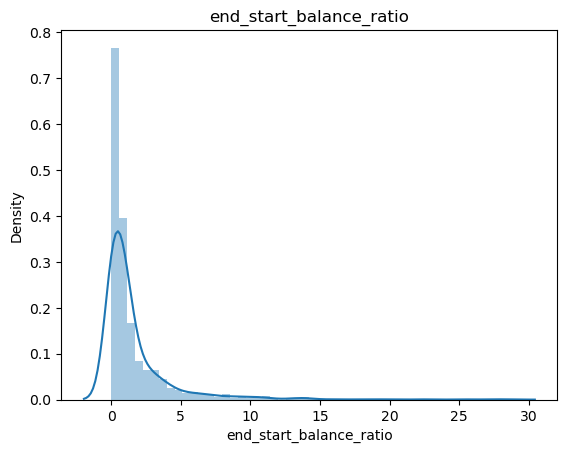

In [82]:
column_names = bk_behaviour.columns[-13:]

for column_name in column_names:
    sns.distplot(bk_behaviour[column_name])
    plt.title(column_name)
    plt.show()

In [93]:
bk_behaviour['cc_av_pm_log'] = np.log(bk_behaviour[bk_behaviour['cc_av_pm'] > 0]['cc_av_pm'])
bk_behaviour['cc_av_wd_log'] = np.log(bk_behaviour[bk_behaviour['cc_av_wd'] > 0]['cc_av_wd'])
bk_behaviour['cc_n_pm_log'] = np.log(bk_behaviour[bk_behaviour['cc_n_pm'] > 0]['cc_n_pm'])
bk_behaviour['ck_av_dp_log'] = np.log(bk_behaviour[bk_behaviour['ck_av_dp'] > 0]['ck_av_dp'])
bk_behaviour['ck_n_wd_log'] = np.log(bk_behaviour[bk_behaviour['ck_n_wd'] > 0]['ck_n_wd'])
bk_behaviour['sv_av_dp_log'] = np.log(bk_behaviour[bk_behaviour['sv_av_dp'] > 0]['sv_av_dp'])
bk_behaviour['sv_n_wd_log'] = np.log(bk_behaviour[bk_behaviour['sv_n_wd'] > 0]['sv_n_wd'])
bk_behaviour['end_start_balance_ratio_log'] = np.log(bk_behaviour[bk_behaviour['end_start_balance_ratio'] > 0]['end_start_balance_ratio'])

In [96]:
bk_behaviour['cc_n_wd_log'] = np.log(bk_behaviour[bk_behaviour['cc_n_wd'] > 0]['cc_n_wd'])

In [97]:
print(bk_behaviour)

      cust_id      acct_nbr acct_type  account_active  starting_balance  \
0     1362806  1.362806e+07        SV               1           1430.22   
1     1362709  4.561140e+15        CC               1            266.34   
2     1362836  4.561140e+15        CC               1             55.90   
3     1363311  1.363311e+07        CK               1          11017.13   
4     1363361  4.561140e+15        CC               1            849.37   
...       ...           ...       ...             ...               ...   
1404  1362556  4.561140e+15        CC               0           1433.94   
1405  1362624  4.561140e+15        CC               1            632.75   
1406  1362875  4.561140e+15        CC               1           2810.91   
1407  1362654  1.362654e+07        SV               1            784.53   
1408  1362703  1.362703e+07        CK               1           3649.18   

      ending_balance    cc_av_wd    cc_av_pm  cc_n_wd  cc_n_pm  ...  \
0             284.58        

/Users/brigitte/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


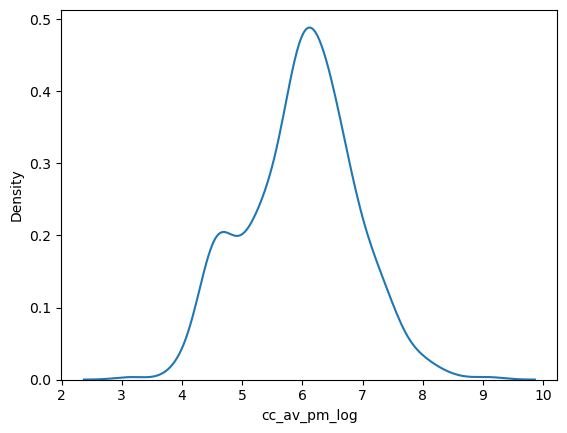

/Users/brigitte/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/brigitte/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2657: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/Users/brigitte/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


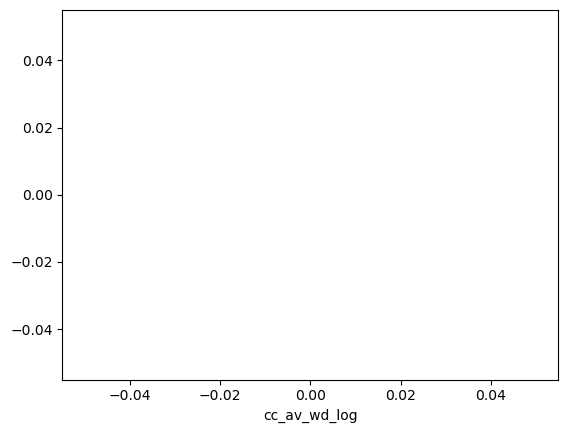

/Users/brigitte/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


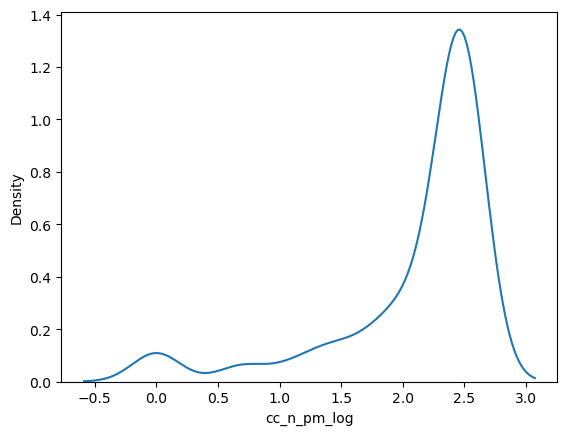

/Users/brigitte/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


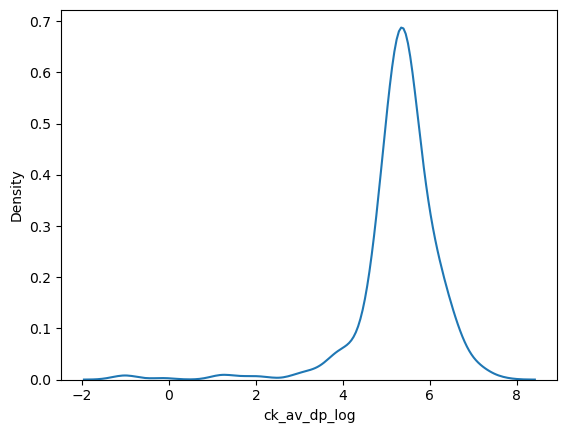

/Users/brigitte/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


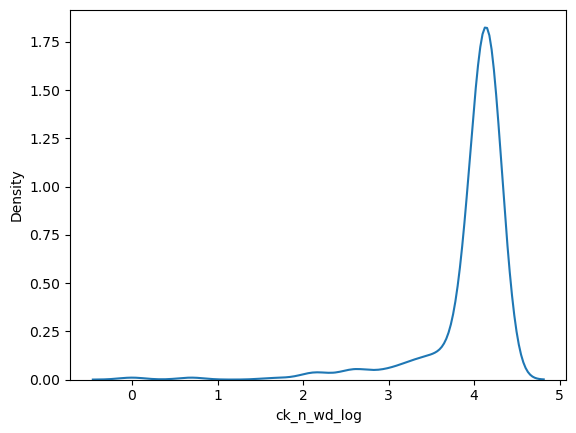

/Users/brigitte/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


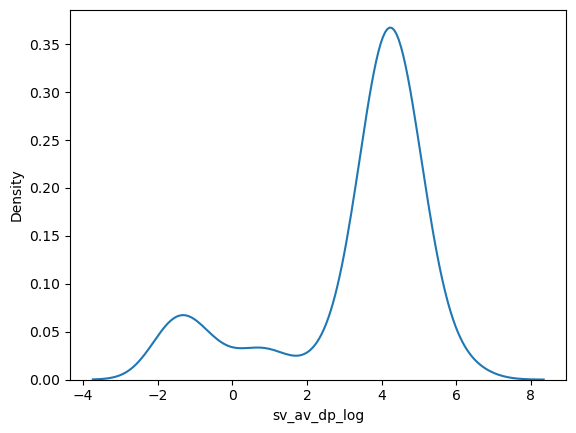

/Users/brigitte/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


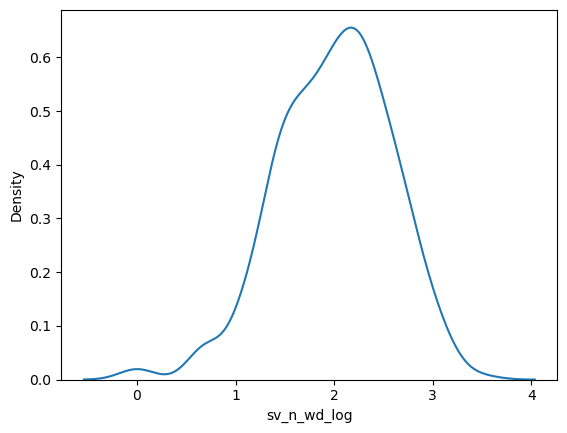

/Users/brigitte/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


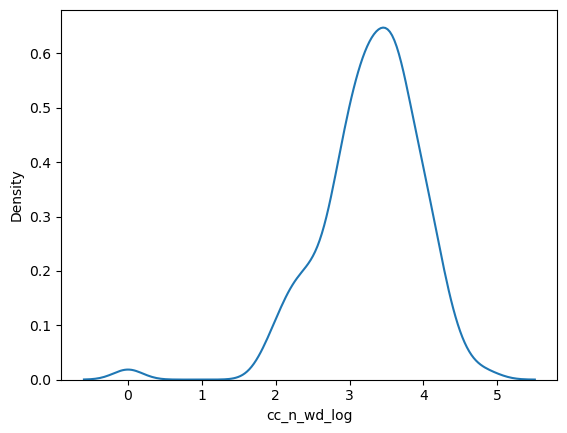

/Users/brigitte/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


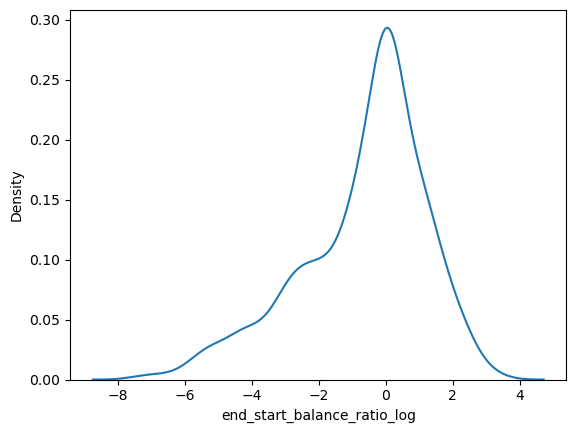

In [98]:
columns = ['cc_av_pm_log', 'cc_av_wd_log', 'cc_n_pm_log', 'ck_av_dp_log', 
           'ck_n_wd_log', 'sv_av_dp_log', 'sv_n_wd_log', 'cc_n_wd_log', 'end_start_balance_ratio_log']

for column in columns:
    sns.distplot(bk_behaviour[column].dropna(), kde=True, hist=False)
    plt.show()

In [100]:
cc_av_wd_yj = stats.yeojohnson(bk_behaviour['cc_av_wd'])[0]
bk_behaviour['cc_av_wd_yj'] = cc_av_wd_yj

/Users/brigitte/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='cc_av_wd_yj', ylabel='Density'>

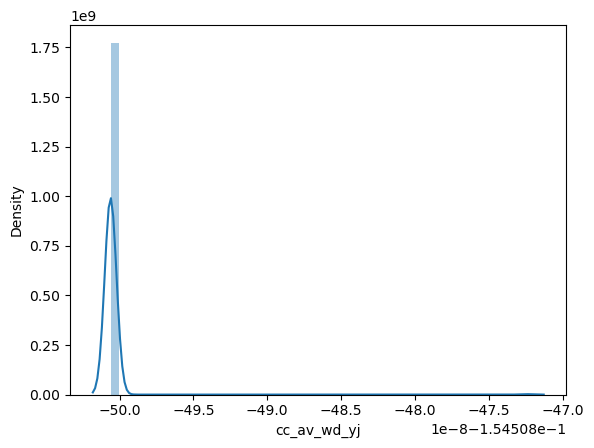

In [101]:
  sns.distplot(bk_behaviour['cc_av_wd_yj'])

In [72]:
column_names = bk_behaviour.columns[-13:]
for column_name in column_names:
    print(f"Scaling column: {column_name}")
    scaler = MinMaxScaler()
    column = bk_behaviour[[column_name]]
    scaled_column = pd.DataFrame(scaler.fit_transform(column), columns=[column_name + "_scaled"])
    bk_behaviour[column_name + "_scaled"] = scaled_column
print(bk_behaviour)

Scaling column: cc_av_wd
Scaling column: cc_av_pm
Scaling column: cc_n_wd
Scaling column: cc_n_pm
Scaling column: ck_av_wd
Scaling column: ck_av_dp
Scaling column: ck_n_wd
Scaling column: ck_n_dp
Scaling column: sv_av_wd
Scaling column: sv_av_dp
Scaling column: sv_n_wd
Scaling column: sv_n_dp
Scaling column: end_start_balance_ratio
      cust_id      acct_nbr acct_type  account_active  starting_balance  \
0     1362806  1.362806e+07        SV               1           1430.22   
1     1362709  4.561140e+15        CC               1            266.34   
2     1362836  4.561140e+15        CC               1             55.90   
3     1363311  1.363311e+07        CK               1          11017.13   
4     1363361  4.561140e+15        CC               1            849.37   
...       ...           ...       ...             ...               ...   
1404  1362556  4.561140e+15        CC               0           1433.94   
1405  1362624  4.561140e+15        CC               1            6

In [58]:
bk_behaviour.to_csv('Data/banking_behaviour_data/banking_behaviour_datasc.csv', index = False)